In [6]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def reset_env(env):
    result = env.reset()
    if isinstance(result, tuple):
        return result[0]
    else:
        return result

In [8]:
def step_env(env, action):
    result = env.step(action)
    # New API returns (obs, reward, terminated, truncated, info)
    if isinstance(result, tuple):
        if len(result) == 5:
            next_state, reward, terminated, truncated, info = result
            done = terminated or truncated
            return next_state, reward, done, info
        # Old API returns (obs, reward, done, info)
        elif len(result) == 4:
            next_state, reward, done, info = result
            return next_state, reward, done, info
    return result

In [9]:
env = gym.make('CartPole-v1', new_step_api=True)

In [10]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=-1)

In [11]:
def reinforce(env, policy_network, optimizer, num_episodes=1000, gamma=0.99):
    episode_rewards = []

    for episode in range(num_episodes):
        state = reset_env(env)  # Use helper for reset
        done = False
        rewards = []
        log_probs = []

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action_probs = policy_network(state_tensor)
            action = torch.multinomial(action_probs, 1).item()

            next_state, reward, done, info = step_env(env, action)  # Use helper for step
            log_prob = torch.log(action_probs.squeeze(0)[action])

            rewards.append(reward)
            log_probs.append(log_prob)
            state = next_state

        episode_rewards.append(sum(rewards))

        # Compute returns (discounted cumulative rewards)
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.FloatTensor(returns)

        # Normalize returns for stability
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        # Compute policy gradient loss
        loss = -torch.sum(torch.stack(log_probs) * returns)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print reward and loss every 100 episodes
        if episode % 100 == 0:
            print(f"Episode {episode}: Reward = {sum(rewards)} | Loss = {loss.item()}")

    return episode_rewards


In [12]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
policy_network = PolicyNetwork(state_dim, action_dim)
optimizer = optim.Adam(policy_network.parameters(), lr=0.01)
rewards = reinforce(env, policy_network, optimizer, num_episodes=1000)

Episode 0: Reward = 15.0 | Loss = -1.113202691078186
Episode 100: Reward = 23.0 | Loss = -0.30722564458847046
Episode 200: Reward = 99.0 | Loss = 4.612116813659668
Episode 300: Reward = 500.0 | Loss = 0.7265437841415405
Episode 400: Reward = 500.0 | Loss = 0.5126385688781738
Episode 500: Reward = 500.0 | Loss = 7.738801956176758
Episode 600: Reward = 188.0 | Loss = -1.5916892290115356
Episode 700: Reward = 500.0 | Loss = -1.4137861728668213
Episode 800: Reward = 500.0 | Loss = -1.1349924802780151
Episode 900: Reward = 500.0 | Loss = -10.66139030456543


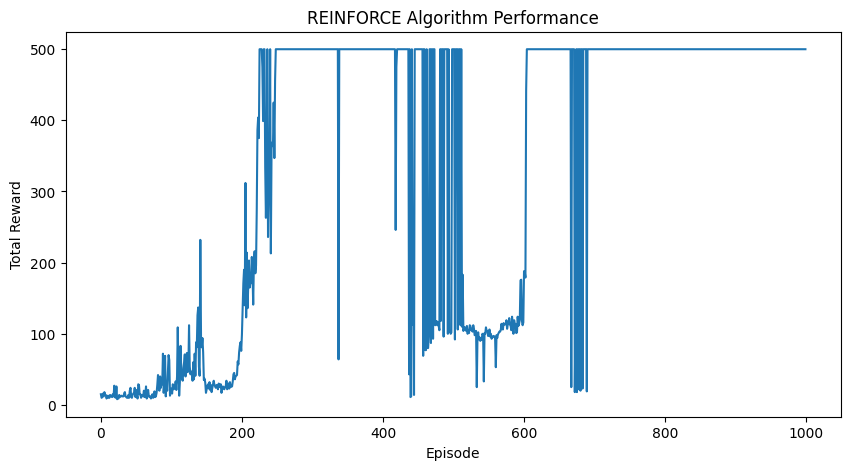

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('REINFORCE Algorithm Performance')
plt.show()

#Conclusion
In conclusion, the code effectively implements the REINFORCE algorithm on the CartPole environment while ensuring compatibility with both the old and new Gym APIs. By incorporating helper functions to handle the differences in the return values of the reset() and step() methods, the code remains robust and adaptable regardless of the Gym version. Additionally, by printing both the loss and the total reward every 100 episodes, it provides clear insights into the training progress and performance stability. The plotted rewards over episodes offer a visual representation of the policy's improvement over time, reinforcing the fundamental concepts of policy gradient methods. This implementation not only demonstrates a practical approach to reinforcement learning but also serves as a strong foundation for further experimentation and enhancements in more complex environments.